# 2025-04-25: Cornell Pressure Sensor Test  
2025-04-25  
Project: misc  
Jonathan Pfeifer  

## Purpose
This is a retest of Nikolai's pressure sensor. I rebuilt the main module and will retest with some additional testing as well to get some characterization data out of it.

## Building the sensor
```{figure} ../images/jb/2025-04-25-decapped-picow.jpg
:name: 2025-04-25-figure-decapped-picow
The first step was to take off the shield on the wireless chip. We hypothesized that this shield might be the reason Nikolai's original failed. I took it upstairs to AVAST and and hit it with the reflow solder and took it off. I also took two small capacitors with it, but since I have no plan to use the wireless features I think this is okay.
```

Then I soldered all the wires and boards together. Unfortunately forgot to take pictures here. But I just followed the images Nikolai provided for assembly. 

```{figure} ../images/jb/2025-04-25-potting.jpg
:name: 2025-04-25-figure-potting
The next step was potting the electronics. I used a standard 4N resin and then pulled the strongest vacuum on it that I could (about -0.7bar). I cycled the vacuum on and off, and tapped the box back and forth to get as many air bubbles to come out as possible. After about 5 minutes of this I released the vacuum and allowed it to finish curing overnight
```

```{figure} ../images/jb/2025-04-25-attached-unit.jpg
:name: 2025-04-25-figure-attached-unit
My orientation is different than Nikolai's original. I flipped both the sensor and the magnet around. The sensor has such a short cable that I had to do it this way. 
```

## Code
Here is the app code I am using to collect all the data for these trials. It opens up a GUI you can use. (Note, apparently this app is super glitchy and isn't recording correctly. So just be aware of that. I have now had to go back and re-record data number of times which is frustrating)


In [12]:
#!/usr/bin/env python3

import serial
import csv
import datetime
import os
import tkinter as tk
from tkinter import ttk, messagebox
from serial.tools import list_ports
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from time import time

# --- USER SETTINGS ---
SAVE_DIR = "../data/raw/cornell-sensor/"
os.makedirs(SAVE_DIR, exist_ok=True)


class Plotter:
    def __init__(self, ax):
        self.ax = ax
        self.maxt = 10000
        self.tdata = [0]
        self.ydata = {0: [2048], 1: [2048], 2: [2048]}
        self.lines = {
            0: Line2D(self.tdata, self.ydata[0], color='C0', label='ADC0'),
            1: Line2D(self.tdata, self.ydata[1], color='C1', label='ADC1'),
            2: Line2D(self.tdata, self.ydata[2], color='C2', label='ADC2'),
        }

        for line in self.lines.values():
            self.ax.add_line(line)

        self.ax.set_autoscaley_on(True)
        self.ax.set_autoscalex_on(True)
        self.ax.legend(loc='upper right')

    def update(self, adc_vals):
        if adc_vals is None:
            return tuple(self.lines.values())

        now = time()
        timestamp = int((now - start_time) * 1000)
        human_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        if app.raw_logging:
            app.raw_writer.writerow([human_time, timestamp, adc_vals[0], adc_vals[1], adc_vals[2]])

        if app.custom_logging:
            app.custom_writer.writerow([
                human_time, timestamp, adc_vals[0], adc_vals[1], adc_vals[2],
                app.data_type.get(), app.data_value.get()
            ])

        lastt = self.tdata[-1]
        t = lastt + 1
        self.tdata.append(t)
        for ch in adc_vals:
            self.ydata[ch].append(adc_vals[ch])
            self.lines[ch].set_data(self.tdata, self.ydata[ch])
        self.ax.relim()
        self.ax.autoscale_view()
        if self.tdata:
            xmin = min(self.tdata)
            xmax = max(self.tdata)
            self.ax.set_xlim(xmin, xmax + (xmax - xmin) * 0.05 if xmax > xmin else xmax + 10)


        return tuple(self.lines.values())


def serial_getter():
    buffer = {0: [], 1: [], 2: []}
    last_emit_time = time()
    discard_count = 1

    while True:
        line = app.ser.readline().decode(errors='ignore').strip()
        if line.startswith("ADC"):
            try:
                parts = line.split(":")
                chan = int(parts[0][3])
                val = int(parts[1].strip())
                buffer[chan].append(val)
            except Exception:
                continue

        if time() - last_emit_time >= 1 and all(buffer[ch] for ch in [0, 1, 2]):
            last_emit_time = time()
            if discard_count > 0:
                discard_count -= 1
                buffer = {0: [], 1: [], 2: []}
                continue

            avg_vals = {
                ch: int(sum(buffer[ch]) / len(buffer[ch])) if buffer[ch] else 2048
                for ch in buffer
            }
            yield avg_vals
            buffer = {0: [], 1: [], 2: []}


class App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("3-Channel ADC Logger")

        self.raw_logging = False
        self.custom_logging = Fal     
        self.ser = None
        self.custom_file = None
        self.raw_file = None

        # Variables
        self.filename_var = tk.StringVar()
        self.data_type = tk.StringVar()
        self.data_value = tk.StringVar()
        self.com_port = tk.StringVar()

        # COM Port selector
        ttk.Label(self, text="COM Port:").grid(row=0, column=0)
        self.com_ports = [p.device for p in list_ports.comports()]
        self.com_port.set(self.com_ports[0] if self.com_ports else "")
        self.com_dropdown = ttk.Combobox(self, values=self.com_ports, textvariable=self.com_port, state="readonly")
        self.com_dropdown.grid(row=0, column=1, columnspan=2)

        # Logging controls
        ttk.Label(self, text="CSV Filename Prefix:").grid(row=1, column=0)
        ttk.Entry(self, textvariable=self.filename_var).grid(row=1, column=1)
        ttk.Button(self, text="Start Raw Logging", command=self.start_raw).grid(row=1, column=2)
        ttk.Button(self, text="Stop Raw Logging", command=self.stop_raw).grid(row=1, column=3)

        ttk.Label(self, text="Data Type:").grid(row=2, column=0)
        ttk.Entry(self, textvariable=self.data_type).grid(row=2, column=1)
        ttk.Label(self, text="Data Value:").grid(row=2, column=2)
        ttk.Entry(self, textvariable=self.data_value).grid(row=2, column=3)
        ttk.Button(self, text="Start Custom Logging", command=self.start_custom).grid(row=2, column=4)
        ttk.Button(self, text="Stop Custom Logging", command=self.stop_custom).grid(row=2, column=5)

        # Status box
        ttk.Label(self, text="Status:").grid(row=4, column=0, sticky='e')
        self.status_text = tk.StringVar(value="Idle")
        ttk.Label(self, textvariable=self.status_text, foreground="blue").grid(row=4, column=1, columnspan=4, sticky='w')

        # Plot
        fig, ax = plt.subplots()
        self.plotter = Plotter(ax)
        self.canvas = FigureCanvasTkAgg(fig, master=self)
        self.canvas.get_tk_widget().grid(row=3, column=0, columnspan=6)

        self.ani = None
        self.protocol("WM_DELETE_WINDOW", self.on_close)

    def update_status(self, message):
        self.status_text.set(message)

    def init_serial(self):
        try:
            self.ser = serial.Serial(self.com_port.get(), 115200, timeout=1)
            global start_time
            start_time = time()
            if not self.ani:
                self.ani = FuncAnimation(self.plotter.ax.figure, self.plotter.update, serial_getter,
                                         interval=1, blit=True, cache_frame_data=False)
        except Exception as e:
            messagebox.showerror("Serial Error", f"Failed to open serial port: {e}")
            return False
        return True

    def start_raw(self):
        if not self.ser and not self.init_serial():
            return
        filename = self.filename_var.get().strip()
        if not filename:
            self.update_status("Filename required.")
            return

        # Create a unique filename with timestamp to prevent overwrite
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d")
        raw_filename = f"{timestamp}-{filename}[raw].csv"
        path = os.path.join(SAVE_DIR, raw_filename)

        self.raw_file = open(path, "w", newline='')
        self.raw_writer = csv.writer(self.raw_file)
        self.raw_writer.writerow(["datetime", "ms_elapsed", "ADC0", "ADC1", "ADC2"])
        self.raw_logging = True
        self.update_status(f"Started raw logging to {raw_filename}")

    def stop_raw(self):
        if self.raw_logging and self.raw_file:
            self.raw_file.close()
            self.raw_file = None
        self.raw_logging = False
        self.update_status("Stopped raw logging.")

    def start_custom(self):
        if not self.ser and not self.init_serial():
            return
        filename = self.filename_var.get().strip()
        if not filename:
            self.update_status("Filename required.")
            return
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d")
        path = os.path.join(SAVE_DIR, f"{timestamp}-{filename}[customfield].csv")
        if self.custom_file is None:
            file_exists = os.path.exists(path)
            self.custom_file = open(path, "a", newline='')
            self.custom_writer = csv.writer(self.custom_file)
            if not file_exists:
                self.custom_writer.writerow(["datetime", "ms_elapsed", "ADC0", "ADC1", "ADC2", "DataType", "DataValue"])
        self.custom_logging = True
        self.update_status("Started custom logging.")

    def stop_custom(self):
        self.custom_logging = False
        self.update_status("Stopped custom logging.")

    def on_close(self):
        self.stop_raw()
        self.stop_custom()
        if self.custom_file:
            self.custom_file.close()
            self.custom_file = None
        if self.ser and self.ser.is_open:
            self.ser.close()
        self.destroy()


# Run the app
#app = App()
#app.mainloop()


## Distance Test

One of the first things I want to know is what hall effect measurements are which distance unit. I took a ruler and marked every 2mm along the opening of the housing for the magnet. I then used a screwdriver to position the magnet shuttle at each stop and recorded the resulting readings. I used the bottom o-ring as the location index of the shuttle since it is easier to see than the edge of the red part. 
```{figure} ../images/jb/2025-04-25-ruler.jpg
:name: 2025-04-25-figure-ruler
Here is the ruler that I marked onto the unit. I used a screwdriver and a zip tie to align the magnet back and forth. I made sure to pull of the screwdriver before measuring that it wouldn't alter the magnetic flux of the magnet.  
```

I went back and forth a couple of times recording the readings at each mark. 

### Distance Test Results

In [13]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# 1. Load the CSV
df = pd.read_csv('2025-04-25-distance-test-[customfield].csv', parse_dates=['datetime'])

# 2. Bin by DataValue and compute mean ADC values per bin
binned = df.groupby('DataValue').agg({
    'ADC0': 'mean',
    'ADC1': 'mean',
    'ADC2': 'mean'
}).reset_index()

# 3. Plot with Plotly
fig = go.Figure()

# Add a line for each ADC channel
for adc_col in ['ADC0', 'ADC1', 'ADC2']:
    fig.add_trace(go.Scatter(
        x=binned['DataValue'],
        y=binned[adc_col],
        mode='lines+markers',
        name=adc_col
    ))

# 4. Format the plot
fig.update_layout(
    title='ADC Values vs Distance',
    xaxis_title='Distance (mm)',
    yaxis_title='ADC Value',

)

fig.show()
#binned.to_csv('../data/processed/cornell-sensor/2025-04-25-distance-test-binned.csv', index=False)

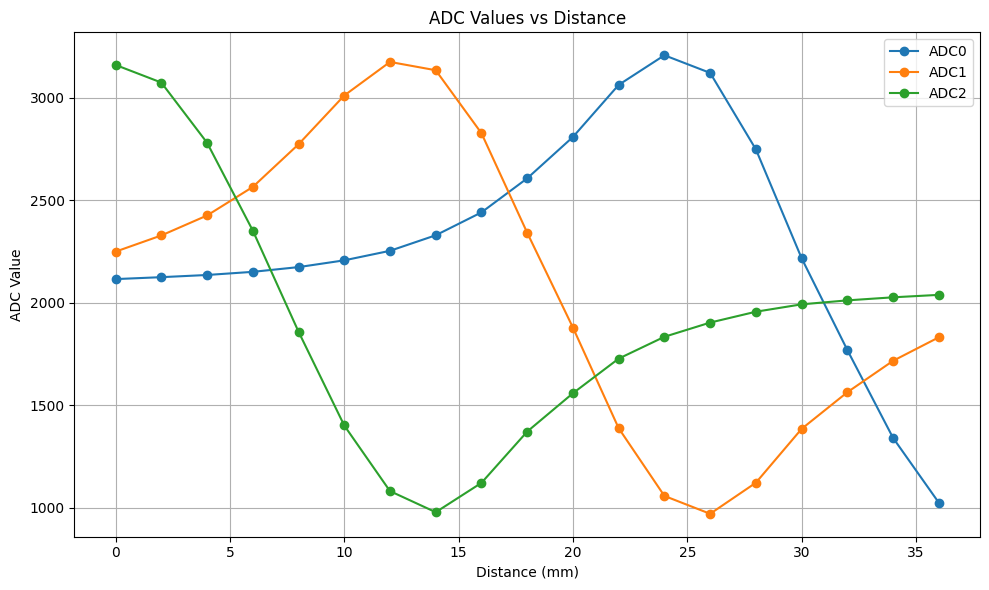

In [14]:
# Create a matplotlib plot
plt.figure(figsize=(10, 6))

# Plot each ADC channel
for adc_col in ['ADC0', 'ADC1', 'ADC2']:
    plt.plot(binned['DataValue'], binned[adc_col], marker='o', label=adc_col)

# Format the matplotlib plot
plt.title('ADC Values vs Distance')
plt.xlabel('Distance (mm)')
plt.ylabel('ADC Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the matplotlib plot
plt.show()

Fitted values:
  ADC0: x = 10.29 mm, z = 30.99 mm
  ADC1: x = 10.47 mm, z = 19.16 mm
  ADC2: x = 10.50 mm, z = 7.00 mm


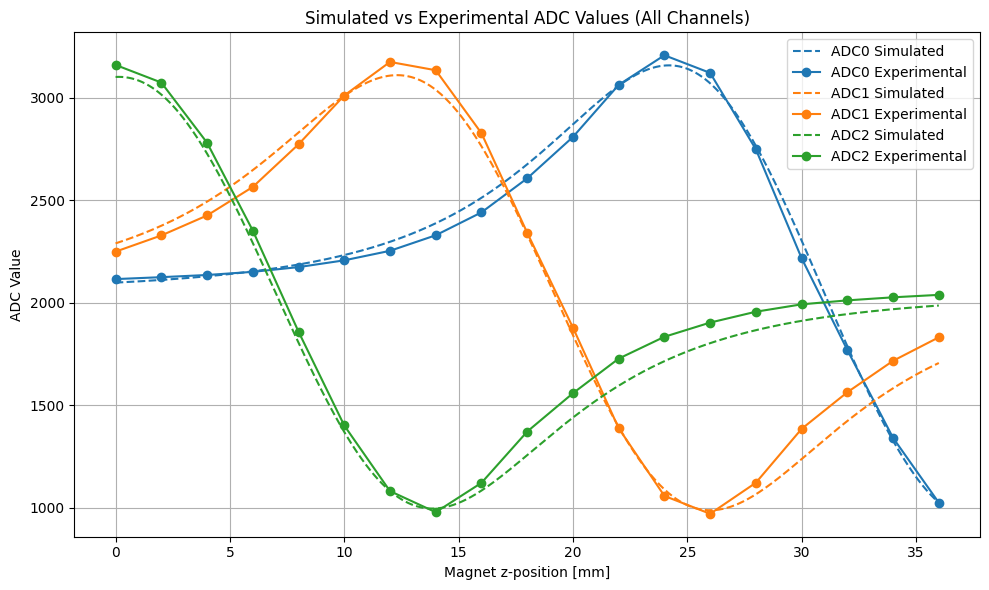

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import magpylib as mag

# --- Load experimental data ---
df = pd.read_csv('2025-04-25-distance-test-[customfield].csv')
binned = df.groupby('DataValue').agg({
    'ADC0': 'mean',
    'ADC1': 'mean',
    'ADC2': 'mean'
}).reset_index()

distance_data = binned['DataValue'].to_numpy()
adc_data = {
    'ADC0': binned['ADC0'].to_numpy(),
    'ADC1': binned['ADC1'].to_numpy(),
    'ADC2': binned['ADC2'].to_numpy()
}

# --- Magnet definition (N42: Br = 1.3T) ---
Br = 1.3  # Tesla
mu0 = 4 * np.pi * 1e-7
M = Br / mu0  # Magnetization in A/m

l_magnet = 11 # height of the magnet (mm)

magnet = mag.magnet.Cylinder(
    magnetization=(0, 0, M),
    dimension=(4, l_magnet)  # diameter, height (mm)
)

# --- Define the model and objective ---
def fit_error(params):
    x_sensors = params[:3]
    z_sensors = params[3:]
    total_error = 0

    for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
        x_sensor = x_sensors[i]
        z_sensor = z_sensors[i]
        sensor_pos = np.array([x_sensor, 0, z_sensor])
        adc_vals = []

        for z_mag in distance_data:
            magnet.position = (0, 0, z_mag)
            B = magnet.getB(sensor_pos)
            voltage = B[0] * 100 + 3.3 / 2
            adc_val = voltage / (3.3 / 4096)
            adc_vals.append(adc_val)

        sim = np.array(adc_vals)
        total_error += np.mean((sim - adc_data[ch]) ** 2)

    return total_error / 3

# --- Optimize x0, x1, x2, z0, z1, z2 ---
initial_guess = [10, 10, 10, 32, 20, 8]
bounds = [(0, 25)] * 3 + [(0, 40)] * 3
result = minimize(fit_error, initial_guess, bounds=bounds)

x_sensors = result.x[:3]
z_sensors = result.x[3:]
print("Fitted values:")
for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
    print(f"  {ch}: x = {x_sensors[i]:.2f} mm, z = {z_sensors[i]:.2f} mm")

# --- Simulate over smooth range for plotting ---
z_range = np.linspace(min(distance_data), max(distance_data), 1000)
adc_sim = {}

for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
    x_sensor = x_sensors[i]
    z_sensor = z_sensors[i]
    sensor_pos = np.array([x_sensor, 0, z_sensor])
    adc_vals = []

    for z_mag in z_range:
        magnet.position = (0, 0, z_mag)
        B = magnet.getB(sensor_pos)
        voltage = B[0] * 100 + 3.3 / 2
        adc_val = voltage / (3.3 / 4096)
        adc_vals.append(adc_val)

    adc_sim[ch] = np.array(adc_vals)

# --- Plot ---
colors = ['C0', 'C1', 'C2']
plt.figure(figsize=(10, 6))
for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
    plt.plot(z_range, adc_sim[ch], '--', label=f'{ch} Simulated', color=colors[i])
    plt.plot(distance_data, adc_data[ch], 'o-', label=f'{ch} Experimental', color=colors[i])

plt.title('Simulated vs Experimental ADC Values (All Channels)')
plt.xlabel('Magnet z-position [mm]')
plt.ylabel('ADC Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Fitted values:
  ADC0: x = 10.22 mm, z = 30.88 mm
  ADC1: x = 10.30 mm, z = 19.25 mm
  ADC2: x = 10.38 mm, z = 7.21 mm
  Optimized magnet height: 10.74 mm

R² values (per channel):
  ADC0: R² = 0.9977
  ADC1: R² = 0.9984
  ADC2: R² = 0.9990


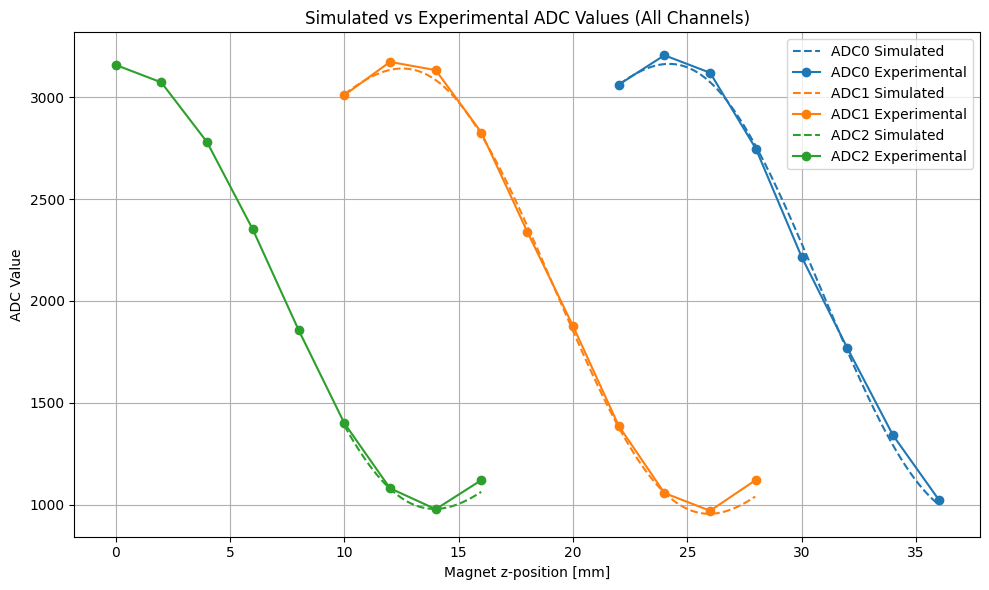

In [89]:
# --- Load experimental data ---
df = pd.read_csv('2025-04-25-distance-test-[customfield].csv')

# --- Define per-channel distance filter ranges ---
distance_ranges = {
    'ADC0': (22, 36),
    'ADC1': (10, 28),
    'ADC2': (0, 16)
}

# --- Filter and group for each channel ---
adc_data = {}
distance_data = {}

for ch in ['ADC0', 'ADC1', 'ADC2']:
    dmin, dmax = distance_ranges[ch]
    mask = (df['DataValue'] >= dmin) & (df['DataValue'] <= dmax)
    grouped = df.loc[mask].groupby('DataValue').agg({ch: 'mean'}).reset_index()
    distance_data[ch] = grouped['DataValue'].to_numpy()
    adc_data[ch] = grouped[ch].to_numpy()

# --- Magnet constant setup (N42: Br = 1.3T) ---
Br = 1.3  # Tesla
mu0 = 4 * np.pi * 1e-7
M = Br / mu0  # Magnetization in A/m

# --- Define the model and objective ---
def fit_error(params):
    x_sensors = params[:3]
    z_sensors = params[3:6]
    l_magnet = params[6]  # optimize magnet height too

    # Create new magnet for this iteration
    magnet = mag.magnet.Cylinder(
        magnetization=(0, 0, M),
        dimension=(4, l_magnet)
    )

    total_error = 0
    for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
        x_sensor = x_sensors[i]
        z_sensor = z_sensors[i]
        sensor_pos = np.array([x_sensor, 0, z_sensor])
        adc_vals = []

        for z_mag in distance_data[ch]:
            magnet.position = (0, 0, z_mag)
            B = magnet.getB(sensor_pos)
            voltage = B[0] * 100 + 3.3 / 2
            adc_val = voltage / (3.3 / 4096)
            adc_vals.append(adc_val)

        sim = np.array(adc_vals)
        total_error += np.mean((sim - adc_data[ch]) ** 2)

    return total_error / 3

# --- Optimize x0, x1, x2, z0, z1, z2, l_magnet ---
initial_guess = [10, 10, 10, 32, 20, 8, 11]  # last is magnet height
bounds = [(0, 25)] * 3 + [(0, 40)] * 3 + [(5, 20)]  # include bounds for l_magnet
result = minimize(fit_error, initial_guess, bounds=bounds)

x_sensors = result.x[:3]
z_sensors = result.x[3:6]
l_magnet = result.x[6]  # optimized magnet height

print("Fitted values:")
for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
    print(f"  {ch}: x = {x_sensors[i]:.2f} mm, z = {z_sensors[i]:.2f} mm")
print(f"  Optimized magnet height: {l_magnet:.2f} mm")

# --- Simulate over smooth range for plotting ---
z_range = np.linspace(10, 45, 1000)
adc_sim = {}

# Use optimized magnet
magnet = mag.magnet.Cylinder(
    magnetization=(0, 0, M),
    dimension=(4, l_magnet)
)

for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
    x_sensor = x_sensors[i]
    z_sensor = z_sensors[i]
    sensor_pos = np.array([x_sensor, 0, z_sensor])
    adc_vals = []

    for z_mag in z_range:
        magnet.position = (0, 0, z_mag)
        B = magnet.getB(sensor_pos)
        voltage = B[0] * 100 + 3.3 / 2
        adc_val = voltage / (3.3 / 4096)
        adc_vals.append(adc_val)

    adc_sim[ch] = np.array(adc_vals)

# --- R² evaluation ---
print("\nR² values (per channel):")
for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
    y_true = adc_data[ch]
    y_pred = []

    x_sensor = x_sensors[i]
    z_sensor = z_sensors[i]
    sensor_pos = np.array([x_sensor, 0, z_sensor])

    for z_mag in distance_data[ch]:
        magnet.position = (0, 0, z_mag)
        B = magnet.getB(sensor_pos)
        voltage = B[0] * 100 + 3.3 / 2
        adc_val = voltage / (3.3 / 4096)
        y_pred.append(adc_val)

    y_pred = np.array(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    print(f"  {ch}: R² = {r2:.4f}")

# --- Plot ---
colors = ['C0', 'C1', 'C2']
plt.figure(figsize=(10, 6))
for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
    # Mask z_range to only show in experimental range
    z_min = distance_data[ch].min()
    z_max = distance_data[ch].max()
    sim_mask = (z_range >= z_min) & (z_range <= z_max)

    plt.plot(z_range[sim_mask], adc_sim[ch][sim_mask], '--', label=f'{ch} Simulated', color=colors[i])
    plt.plot(distance_data[ch], adc_data[ch], 'o-', label=f'{ch} Experimental', color=colors[i])

plt.title('Simulated vs Experimental ADC Values (All Channels)')
plt.xlabel('Magnet z-position [mm]')
plt.ylabel('ADC Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [90]:
print("\nSimulated ADC Range Summary:")
for ch in ['ADC0', 'ADC1', 'ADC2']:
    # Mask to experimental range
    z_min = distance_data[ch].min()
    z_max = distance_data[ch].max()
    sim_mask = (z_range >= z_min) & (z_range <= z_max)

    adc_vals = adc_sim[ch][sim_mask]
    adc_min = np.min(adc_vals)
    adc_max = np.max(adc_vals)
    span = adc_max - adc_min

    print(f"  {ch}: min = {adc_min:.1f}, max = {adc_max:.1f}, span = {span:.1f}")


Simulated ADC Range Summary:
  ADC0: min = 1000.4, max = 3163.8, span = 2163.4
  ADC1: min = 954.8, max = 3141.2, span = 2186.4
  ADC2: min = 978.8, max = 1388.3, span = 409.5


In [74]:
result

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1116.3769318570792
        x: [ 1.022e+01  1.030e+01  1.038e+01  3.088e+01  1.925e+01
             7.208e+00  1.074e+01]
      nit: 13
      jac: [ 2.274e-03 -7.594e-03  6.821e-03  2.842e-03 -1.012e-02
            -5.457e-04  2.547e-03]
     nfev: 136
     njev: 17
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

Honestly this fitting above isn't that great, hmm.

Data above was fit maximizing the slope of the active region of the sensor, probably smarter to find the intercept of the data at 4096 / 2 and set the z-value to that

Now, I need to write a function that based on a provided ADC values for a channel, computes the z-position from the fitted data. I want to use the ADC channel with the greatest slope to compute the z-position as there is the most positional data then

Based on the graphs above, this seems to be a pretty good fit, yet it appears to be lacking the **steepness** of the experimental data for some reason. **TRY FITTING MAGNET LENGTH**

So based on this, this full range is pretty sensitive. to get maximum sensitivity during pressure test I might want to have the shuttle start at 6mm on my scale. That way I can detect the smallest changes in pressure in the system. 

This equation looks about as expected per the datasheet example provided from [Texas Instruments](https://www.ti.com/lit/an/slya051b/slya051b.pdf?ts=1730933639285&ref_url=https%253A%252F%252Fwww.ti.com%252Flit%252Fpo%252Fslyt824b%252Fslyt824b.pdf%253Fts%253D1730891260896)

## Pressure test

pressure test 1 file is just the venting process. Saw a dramatic change in values just from that. not sure why exactly. 
- Actually, this file is empty, I must have forgotten to hit start recording. But basically I just saw the signal of the shuttle moving and not coming back to the original position. The start of the next file shows the starting position anyways, so hopefully it isn't a tragic loss.

pressure test 2 was a basic pressurizing test to failure. I heard a crunch/pop sound around 230 bar (I think, I was wearing my headphones but heard something strange) and then the system stopped sending data. 

```{figure} ../images/jb/2025-04-25-start-position.jpg
:name: 2025-04-25-figure-start-position
The starting position of the shuttle
```
```{figure} ../images/jb/2025-04-25-distance-set.jpg
:name: 2025-04-25-figure-distance-set
marked the back plug so i could get consistent volume on it in future tests
```



```{figure} ../images/jb/2025-04-25-pre-pressure-test.jpg
:name: 2025-04-25-figure-pre-pressure-test
pre pressure test, had it set at 6mm and there was a couple bubbles here and there
```
```{figure} ../images/jb/2025-04-25-post-test.jpg
:name: 2025-04-25-figure-post-test
post test the shuttle had moved a good amount to about 11mm and there weren't any bubbles to be seen
```



```{figure} ../images/jb/2025-04-25-top-post-test.jpg
:name: 2025-04-25-figure-top-post-test
after the test there wasn't anything obviously wrong. There were a couple more holes on the surface, but none of them looked super deep or anything, just as though the surface layer popped and the surface bubble below the surface revealed itself.
```
```{figure} ../images/jb/2025-04-25-post-test-position.jpg
:name: 2025-04-25-figure-post-test-position
Here is an image to keep track of the position for volume calculations later. The end of the shuttle is 28mm from the end of the tube (this for the 11mm position that can be seen above in the photo). Due to refraction at this viewing angle it looks like the bottom of shuttle isn't at 0, but it is if you look at it directly from above.
```







### Results

### Venting air results

In [15]:
import pandas as pd
import plotly.graph_objects as go

# 1. Load the CSV
pt2 = pd.read_csv('2025-04-25-pressure-test-2[raw].csv', parse_dates=['datetime'])

# 2. Bin by DataValue and compute mean ADC values per bin


# 3. Plot with Plotly
fig = go.Figure()

# Add a line for each ADC channel
for adc_col in ['ADC0', 'ADC1', 'ADC2']:
    fig.add_trace(go.Scatter(
        x=pt2['datetime'],
        y=pt2[adc_col],
        mode='lines+markers',
        name=adc_col
    ))

# 4. Format the plot
fig.update_layout(
    title='ADC Values vs Pressure',
    xaxis_title='Pressure (bar)',
    yaxis_title='ADC Value',

)

fig.show()


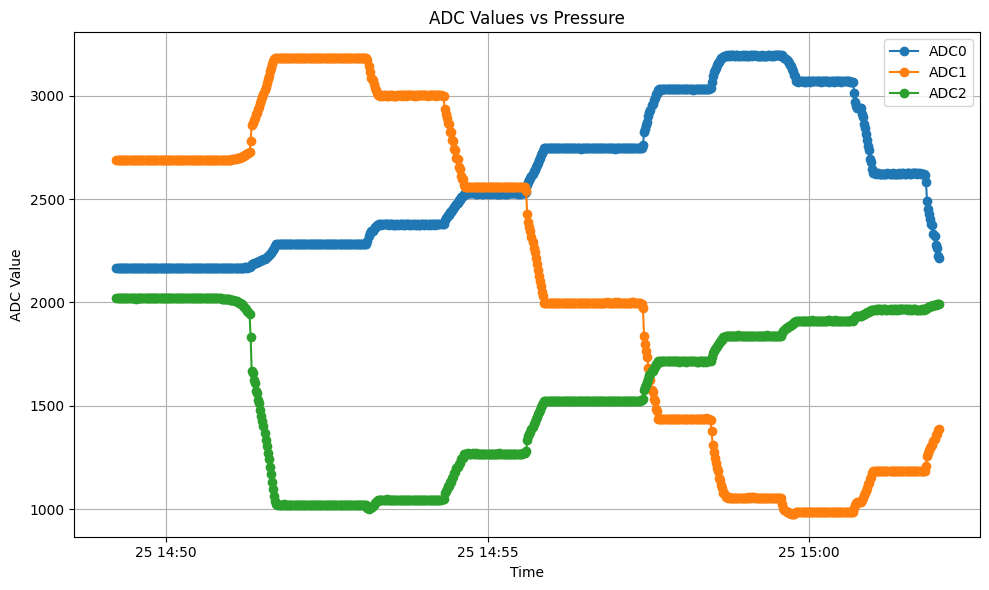

In [17]:
# 5. Matplotlib version of the same plot
plt.figure(figsize=(10, 6))

for adc_col in ['ADC0', 'ADC1', 'ADC2']:
    plt.plot(pt2['datetime'], pt2[adc_col], marker='o', label=adc_col)

plt.title('ADC Values vs Pressure')
plt.xlabel('Time')
plt.ylabel('ADC Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
pressure_slice_ranges = [0,"14:49:30","14:50:43"],[20,"14:51:50","14:52:59"],[40,"14:53:27","14:54:11"],[60,"14:54:44","14:55:30"],[80,"14:55:59","14:57:14"],[100,"14:57:43","14:58:22"],[120,"14:58:48","14:59:29"],[140,"14:59:57","15:00:37"],[160,"15:01:08","15:01:42"]

pt2_slices = []

for pressure, start, end in pressure_slice_ranges:
    # Turn time into datetime with date being 2025-04-25
    start_dt = pd.to_datetime(f"2025-04-25 {start}")
    end_dt = pd.to_datetime(f"2025-04-25 {end}")
    mask = (pt2['datetime'] >= start_dt) & (pt2['datetime'] <= end_dt)
    pt2_slice = pt2.loc[mask].copy()
    pt2_slice["Pressure"] = pressure
    pt2_slices.append(pt2_slice)

# Concatenate all slices into a single DataFrame
pt2_slices = pd.concat(pt2_slices, ignore_index=True)

binned = pt2_slices.groupby('Pressure').agg({
    'ADC0': 'mean',
    'ADC1': 'mean',
    'ADC2': 'mean'
}).reset_index()

# 5. Plot with Plotly
fig = go.Figure()
# Add a line for each ADC channel
for adc_col in ['ADC0', 'ADC1', 'ADC2']:
    fig.add_trace(go.Scatter(
        x=binned['Pressure'],
        y=binned[adc_col],
        mode='lines+markers',
        name=adc_col
    ))

# 4. Format the plot
fig.update_layout(
    title='ADC Values vs Distance',
    xaxis_title='Pressure (bar)',
    yaxis_title='ADC Value',

)
fig.show()
#binned.to_csv("../data/processed/cornell-sensor/2025-04-25-pressure-test-2-binned.csv", index=False)

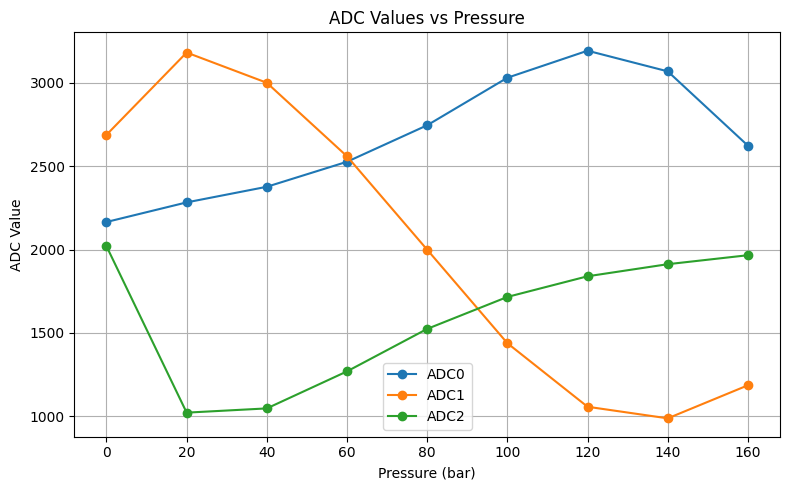

In [78]:
# Matplotlib plot
plt.figure(figsize=(8, 5))
for adc_col in ['ADC0', 'ADC1', 'ADC2']:
    plt.plot(binned['Pressure'], binned[adc_col], marker='o', label=adc_col)

plt.title('ADC Values vs Pressure')
plt.xlabel('Pressure (bar)')
plt.ylabel('ADC Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
from scipy.interpolate import interp1d

# --- Define custom z-ranges where ADC curves are monotonic ---
z_limits = {
    'ADC0': (25, 36),
    'ADC1': (13, 25),
    'ADC2': (1, 13)
}

# --- Simulate fitted ADC curves ---
z_range_full = np.linspace(0, 36, 3600)
adc_lookup = {}

magnet = mag.magnet.Cylinder(
    magnetization=(0, 0, M),
    dimension=(4, l_magnet)
)

for i, ch in enumerate(['ADC0', 'ADC1', 'ADC2']):
    x = x_sensors[i]
    z = z_sensors[i]
    sensor_pos = np.array([x, 0, z])

    adc_vals = []
    for z_mag in z_range_full:
        magnet.position = (0, 0, z_mag)
        B = magnet.getB(sensor_pos)
        voltage = B[0] * 100 + 3.3 / 2
        adc_val = voltage / (3.3 / 4096)
        adc_vals.append(adc_val)

    z_range = np.array(z_range_full)
    adc_vals = np.array(adc_vals)

    # --- Apply custom z-limits for monotonic interpolation ---
    z_min, z_max = z_limits[ch]
    mask = (z_range >= z_min) & (z_range <= z_max)

    adc_sub = adc_vals[mask]
    z_sub = z_range[mask]

    # Optional: check monotonicity
    if not np.all(np.diff(adc_sub) > 0) and not np.all(np.diff(adc_sub) < 0):
        print(f"Warning: {ch} ADC segment in [{z_min}, {z_max}] is not monotonic")

    # Build interpolation: ADC → z
    interp_fn = interp1d(adc_sub, z_sub, bounds_error=False, fill_value=np.nan)
    adc_lookup[ch] = interp_fn

In [113]:
# --- Define which ADC channel to use per pressure range ---
ADC_pressure = [[121, 160], [21, 120], [0, 20]]  # ADC0, ADC1, ADC2
pressure_to_adc_channel = {}

# Build pressure → channel lookup
for i, (pmin, pmax) in enumerate(ADC_pressure):
    for p in range(pmin, pmax + 1):
        pressure_to_adc_channel[p] = f"ADC{i}"

# --- Estimate z-position per pressure ---
estimated_z = []
used_adc = []

for _, row in binned.iterrows():
    pressure = int(row['Pressure'])
    ch = pressure_to_adc_channel.get(pressure)

    if ch:
        adc_val = row[ch]
        z_est = adc_lookup[ch](adc_val)
        estimated_z.append(z_est)
        used_adc.append(ch)
    else:
        estimated_z.append(np.nan)
        used_adc.append(None)

In [114]:
used_adc

['ADC2', 'ADC2', 'ADC1', 'ADC1', 'ADC1', 'ADC1', 'ADC1', 'ADC0', 'ADC0']

In [115]:
estimated_z

[array(7.31863261),
 array(12.66920499),
 array(14.8083637),
 array(17.2089293),
 array(19.43781709),
 array(21.72951515),
 array(24.02469823),
 array(26.042228),
 array(28.62199984)]

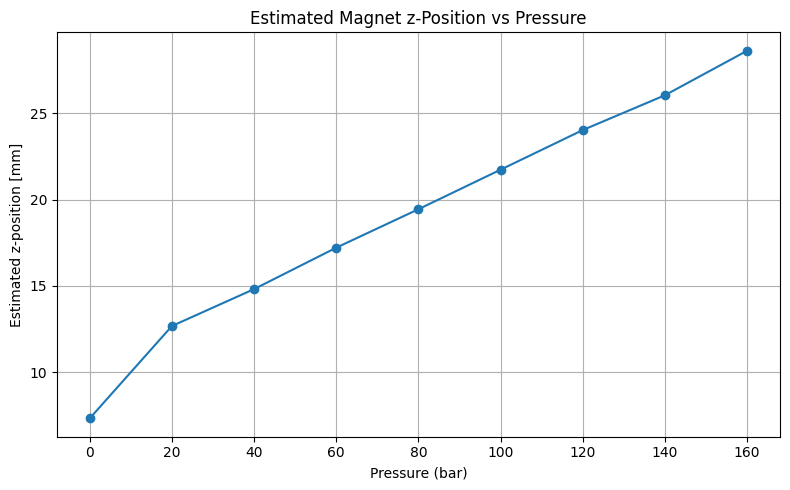

In [116]:
plt.figure(figsize=(8, 5))
plt.plot(binned['Pressure'], estimated_z, marker='o')
plt.title('Estimated Magnet z-Position vs Pressure')
plt.xlabel('Pressure (bar)')
plt.ylabel('Estimated z-position [mm]')
plt.grid(True)
plt.tight_layout()
plt.show()

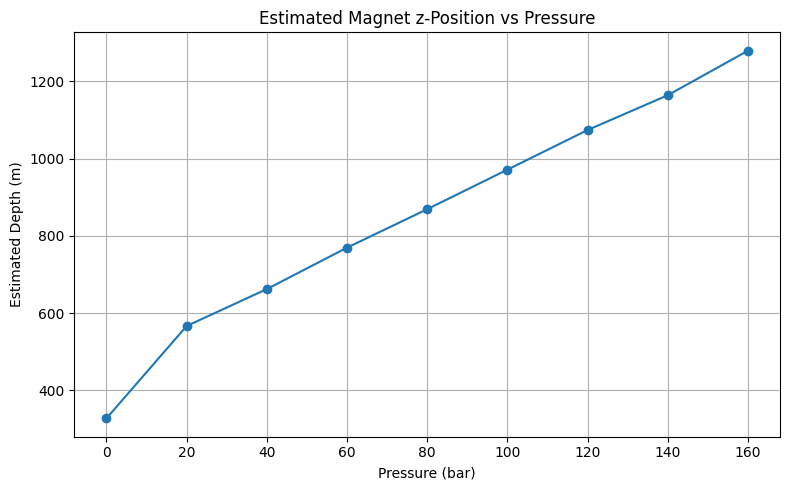

In [123]:
estimated_pressure_m = [z * 4.47 * 10 ** 4 / 1000 for z in estimated_z]
# estimated_pressure_bar = [Pa / 100000 for Pa in estimated_pressure_Pa]

plt.figure(figsize=(8, 5))
plt.plot(binned['Pressure'], estimated_pressure_m, marker='o')
plt.title('Estimated Magnet z-Position vs Pressure')
plt.xlabel('Pressure (bar)')
plt.ylabel('Estimated Depth (m)')
plt.grid(True)
plt.tight_layout()
plt.show()

Now, we can convert the z-position to estimate pressure and volume change

## Failure Analysis
There isn't any serious destruction externally so I took some cross sections with a band saw. 

```{figure} ../images/jb/2025-04-25-cross-section-1.jpg
:name: 2025-04-25-figure-cross-section-1
on first cross section, no obvious failures anywhere
```
```{figure} ../images/jb/2025-04-25-cross-section-2.jpg
:name: 2025-04-25-figure-cross-section-2
Even on multiple cross sections there wasn't an obvious failure mode. 
```
```{figure} ../images/jb/2025-04-25-cross-section-3.jpg
:name: 2025-04-25-figure-cross-section-3
ones that can be flipped are flipped in this one to see the other side.
```

## Volume Measurements
I filled the vessel up to the top with tap water, and then emptied it in to a beaker and measured the mass of the water to get a volume measurement. 
- Pressure vessel: 247.35g
- 5.15g to fill the end tube 101mm of distance (for volume to distance conversions)
